# Waymo: scatterplot - TTC - speed

In [1]:
import pickle
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# import scienceplots
from tqdm import tqdm
from shapely import LineString, Point
from seaborn import displot, histplot, relplot, scatterplot
plt.style.use(['seaborn-v0_8-paper'])
# plt.style.use(['ieee', 'notebook'])

from waymo_devkit.conflict import Conflict

In [2]:
with open('./pkl/conflict_pet15s.pkl', 'rb') as file:
    conflict_list_from_pickle = pickle.load(file)
print(f"#Conflicts: {len(conflict_list_from_pickle)}")

conflict_list = list()
for c in conflict_list_from_pickle:
    conflict_list.append(
        Conflict(
            leader_id=c['leader_id'],
            leader_index=c['leader_index'],
            leader_states=c['leader_states'],
            leader_time_at_conflict=c['leader_time_at_conflict'],
            follower_id=c['follower_id'],
            follower_index=c['follower_index'],
            follower_states=c['follower_states'],
            follower_time_at_conflict=c['follower_time_at_conflict'],
            PET=c['PET'],
            conflict_type=c['conflict_type'],
            leader_is_av=c['leader_is_av'],
            follower_is_av=c['follower_is_av'],
    ))

#Conflicts: 889


/home/gavin/waymo/waymo_devkit/conflict.py:149: RuntimeWarning: divide by zero encountered in double_scalars
  TTCs.append(follower_trajectory_length / (self.follower_beforeConflict_speeds[follower_index]))
/home/gavin/waymo/waymo_devkit/conflict.py:164: RuntimeWarning: divide by zero encountered in double_scalars
  follower_trajectory_length / self.follower_beforeConflict_speeds[follower_index] - \
/home/gavin/waymo/waymo_devkit/conflict.py:165: RuntimeWarning: divide by zero encountered in double_scalars
  leader_trajectory_length / self.leader_beforeConflict_speeds[leader_index]


In [3]:
conflict_cols_in_df = [
    "Conflict type",
    "Vehicle order",
    "PET",
    "TTC",
    "leader_speed",
    "follower_speed",
]

# generate each rows in the dataframe
conflict_rows_in_df = list()
for conflict in conflict_list:
    leader_type = "AV" if conflict.leader_is_av else "HV"
    follower_type = "AV" if conflict.follower_is_av else "HV" 
    conflict_type = "Cross" if conflict.conflict_type == "CROSS" else "Merge"
    PET = conflict.PET

    if conflict.two_vehicles_co_exist:
        states = conflict.states_before_conflictPoint[:, [1,6,7]]
        states = states[~np.isnan(states).any(axis=1)]
        
        for state in states:
            conflict_rows_in_df.append([
                    conflict_type,
                    leader_type+"-"+follower_type,
                    PET,
                    state[0],
                    state[1],
                    state[2],
                ])

conflict_df = pd.DataFrame(conflict_rows_in_df, columns=conflict_cols_in_df)

# Post-process
PET_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["PET"] <= PET_THRESHOLD]

# display info
conflict_df.info(), conflict_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50487 entries, 0 to 51298
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Conflict type   50487 non-null  object 
 1   Vehicle order   50487 non-null  object 
 2   PET             50487 non-null  float64
 3   TTC             50487 non-null  float64
 4   leader_speed    50487 non-null  float64
 5   follower_speed  50487 non-null  float64
dtypes: float64(4), object(2)
memory usage: 2.7+ MB


(None, (50487, 6))

In [4]:
# remove nan value
conflict_df = conflict_df.dropna()
conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50487 entries, 0 to 51298
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Conflict type   50487 non-null  object 
 1   Vehicle order   50487 non-null  object 
 2   PET             50487 non-null  float64
 3   TTC             50487 non-null  float64
 4   leader_speed    50487 non-null  float64
 5   follower_speed  50487 non-null  float64
dtypes: float64(4), object(2)
memory usage: 2.7+ MB


In [5]:
# Post-process: remove TTC greater than 10s
TTC_THRESHOLD = 10
conflict_df = conflict_df[conflict_df["TTC"] <= TTC_THRESHOLD]

# display info
conflict_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23423 entries, 0 to 51265
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Conflict type   23423 non-null  object 
 1   Vehicle order   23423 non-null  object 
 2   PET             23423 non-null  float64
 3   TTC             23423 non-null  float64
 4   leader_speed    23423 non-null  float64
 5   follower_speed  23423 non-null  float64
dtypes: float64(4), object(2)
memory usage: 1.3+ MB


In [6]:
conflict_df["Vehicle order"].value_counts()

AV-HV    10179
HV-HV     8869
HV-AV     4375
Name: Vehicle order, dtype: int64

## Distplots

### All

<Figure size 300x300 with 0 Axes>

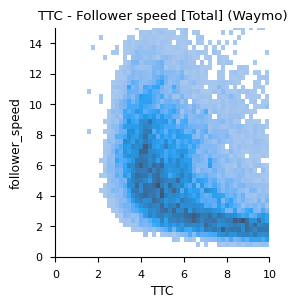

In [16]:
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
conflictType = "Total"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df,
    x="TTC", 
    y="follower_speed",
    height=FIGURE_HEIGHT,
    aspect=1.0,
)

plt.xlim([0, TTC_THRESHOLD])
plt.ylim([0, 15])
# plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"TTC - Follower speed [{conflictType}] (Waymo)")
# plt.savefig(f"./outputs/plots/waymo_distribution_TTC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()

<Figure size 300x300 with 0 Axes>

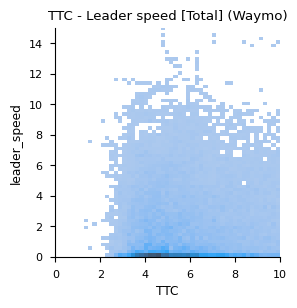

In [17]:
FIGURE_WIDTH, FIGURE_HEIGHT = 3, 3
conflictType = "Total"
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_HEIGHT))

displot(
    data=conflict_df,
    x="TTC", 
    y="leader_speed",
    height=FIGURE_HEIGHT,
    aspect=1.0,
)

plt.xlim([0, TTC_THRESHOLD])
plt.ylim([0, 15])
# plt.legend(["HV-AV", "AV-HV", "HV-HV"], title="Vehicle order")
plt.title(f"TTC - Leader speed [{conflictType}] (Waymo)")
# plt.savefig(f"./outputs/plots/waymo_distribution_TTC_{conflictType}.png", dpi=300, bbox_inches="tight")
plt.show()